#### HW2 - Regresja
RandomForestRegressor i XGBRegressor\
Jan Krężel

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestClassifier

# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Car Prices
Wpierw zajmę się zbiorem car prices. Zaczynam od wczytania danych i prostej obróbki

In [3]:
car_prices = pd.read_csv("data/Car_Prices_Poland.csv", index_col=0)

In [4]:
car_prices.shape

(117927, 10)

In [220]:
car_prices.isna().any()

mark               False
model              False
generation_name     True
year               False
mileage            False
vol_engine         False
fuel               False
city               False
province           False
price              False
dtype: bool

In [221]:
car_prices['generation_name'].isna().sum() / car_prices['generation_name'].shape[0]

0.2551154527801097

Aż 25% danych w kolumnie ```generation_name``` jest brakujących. Ponadto ta kolumna ma wiele klas (pokazane później) i ciężko ją wykorzystać w sposób informatywny. Najlepiej będzie ją wyrzucić.

In [222]:
car_prices.head(10)

,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900
5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,51900
6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,44700
7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,29000
8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,28900
9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,34900


#### Obróbka danych
Sprawdźmy szybko ile jest różnych klas dla zmiennych kategorycznych

In [7]:
def class_count(df, cat_cols):
    for col in cat_cols:
        print(f"{col} has {df[col].unique().shape[0]} unique classes")

In [8]:
cat_cols = ['mark', 'model', 'generation_name', 'fuel', 'city', 'province']
class_count(car_prices, cat_cols)

mark has 23 unique classes
model has 328 unique classes
generation_name has 365 unique classes
fuel has 6 unique classes
city has 4427 unique classes
province has 23 unique classes


Część kolumn ma bardzo dużą liczbę klas i prawdopodobnie nie będą wystarczająco predykcyjne. Sprawdźmy czy istnieje jakaś zależność między atrybutami a ceną.

In [129]:
def plot_price_vs_col(df, cat_cols):
    fig, axes = plt.subplots(len(cat_cols), 1, figsize=(8, len(cat_cols)*5))
    plt.subplots_adjust(hspace=0.5)
    for i, col in enumerate(cat_cols):
        price_median = car_prices.groupby(col)['price'].median()
        price_mean = car_prices.groupby(col)['price'].mean()

        sorted_idx = price_median.argsort()

        price_median = price_median[sorted_idx]
        price_mean = price_mean[sorted_idx]

        axes[i].tick_params(axis='x', rotation=90)
        sns.lineplot(x = price_median.index.to_list(),  y = price_median.values,    ax = axes[i])
        sns.lineplot(x = price_mean.index.to_list(),    y = price_mean.values,      ax = axes[i])

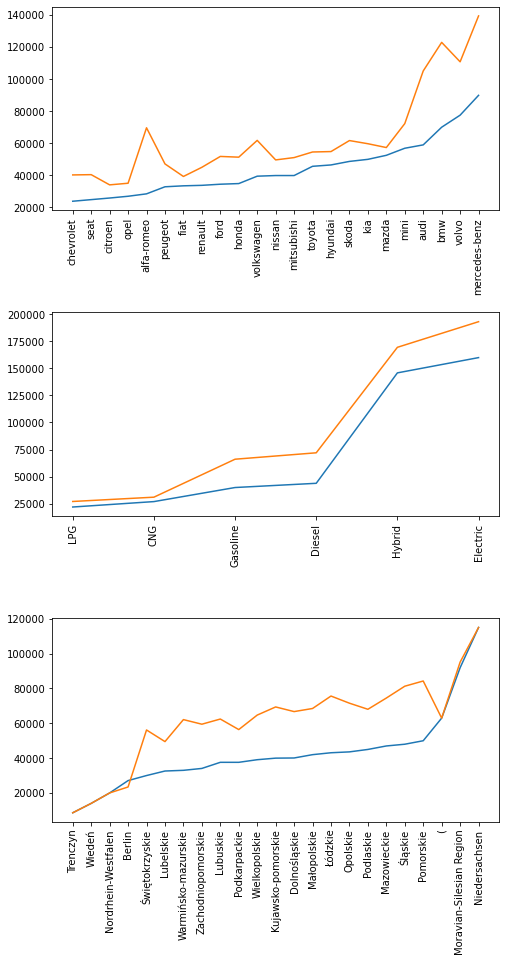

In [132]:
plot_price_vs_col(car_prices, ['mark', 'fuel', 'province'])

Atrybut ```province``` jest rozłożony dość równomiernie. Skoki na krańcach są spowodowane małą liczbą danych (np. widać, że mediana i średnia się pokrywają). Z uwagi na to, że klas jest dość dużo można spróbować ten parametr pominąć.

Jeśli chodzi o markę samochodu to niektóre marki są z reguły droższe. Można spróbować je zakodować i sprawdzić czy model na tym zyska.

W przypadku atrybutu ```fuel``` zakoduję go binarnie według kryterium "is hybrid or electric", ponieważ dla tych dwóch klas ceny się znacznie różnią w porównaniu do pozostałych. Jednocześnie wewnątrz tak stworzonych dwóch klas nie ma dużej wariancji.

Wpierw jednak pozbądźmy się niepotrzebnych kolumn

In [5]:
car_prices = car_prices.drop(['model', 'generation_name', 'city', 'province'], axis=1)

In [6]:
# Zmiana fuel na binary
# jedynka dodana, aby przy ponownym uruchomieniu komórki nie wyzerowały się wszystkie wiersze
car_prices['fuel'] = car_prices['fuel'].isin(['Hybrid', 'Electric', 1]).astype(int)

In [7]:
car_prices

,mark,year,mileage,vol_engine,fuel,price
0,opel,2015,139568,1248,0,35900
1,opel,2018,31991,1499,0,78501
2,opel,2015,278437,1598,0,27000
3,opel,2016,47600,1248,0,30800
4,opel,2014,103000,1400,0,35900
...,...,...,...,...,...,...
117922,volvo,2020,40000,1969,1,222790
117923,volvo,2017,51000,1969,0,229900
117924,volvo,2016,83500,1969,0,135000
117925,volvo,2017,174000,1969,0,154500


In [8]:
# Sprawdzimy też jaka jest różnica między modelem uwzględniającym ```model``` i tym nie uwzględniającym
car_prices_mark = car_prices

In [9]:
# One-hot encoding dla mark
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(car_prices_mark['mark'].values.reshape(-1, 1))
t = enc.transform(car_prices_mark['mark'].values.reshape(-1, 1))
for i, col in enumerate(enc.categories_[0]):
    car_prices_mark[col] = t[:,i].toarray()
# car_prices_mark = car_prices_mark.drop('mark', axis=1)

In [94]:
car_prices_mark

,mark,year,mileage,vol_engine,fuel,price,alfa-romeo,audi,bmw,chevrolet,...,mitsubishi,nissan,opel,peugeot,renault,seat,skoda,toyota,volkswagen,volvo
0,opel,2015,139568,1248,0,35900,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,opel,2018,31991,1499,0,78501,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,opel,2015,278437,1598,0,27000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,opel,2016,47600,1248,0,30800,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,opel,2014,103000,1400,0,35900,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117922,volvo,2020,40000,1969,1,222790,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
117923,volvo,2017,51000,1969,0,229900,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
117924,volvo,2016,83500,1969,0,135000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
117925,volvo,2017,174000,1969,0,154500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Podział zbioru na 70/20/10

In [10]:
def train_val_test_split(X, y, test_size = 0.1, val_size = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size))
    return X_train, X_val, X_test, y_train, y_val, y_test

Wpierw zajmę się ramką z zakodowaną marką samochodu

In [11]:
X = car_prices_mark.drop(['price', 'mark'], axis=1)
y = car_prices_mark['price']
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

## Random Forest Regressor

In [320]:
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=20)

In [322]:
rfr.score(X_val, y_val)

0.8999963485499686

Gird search do wyszukiwania hiperparamtrów

In [387]:
max_depths = np.arange(5, 76, 5)
min_splits = np.logspace(start = -5, stop = -2, num=10)
scores_train = np.empty(shape=(len(max_depths), len(min_splits)))       # bias
scores_val = np.empty(shape=(len(max_depths), len(min_splits)))         # variance

### ! Długi czas wykonywania !

In [15]:
from IPython.display import clear_output

In [427]:
for i, depth in enumerate(max_depths):
    for j, split in enumerate(min_splits):
        # Korzystam tylko z 5, aby przyspieszyć proces
        clear_output(wait=True)
        print(f"Evaluating {i * 10 + j} model...\n")
        rfr = RandomForestRegressor(n_estimators=5, max_depth=depth, min_samples_split=split)
        rfr.fit(X_train, y_train)
        scores_train[i, j] = rfr.score(X_train, y_train)
        scores_val[i, j] = rfr.score(X_val, y_val)


Evaluating 149 model...



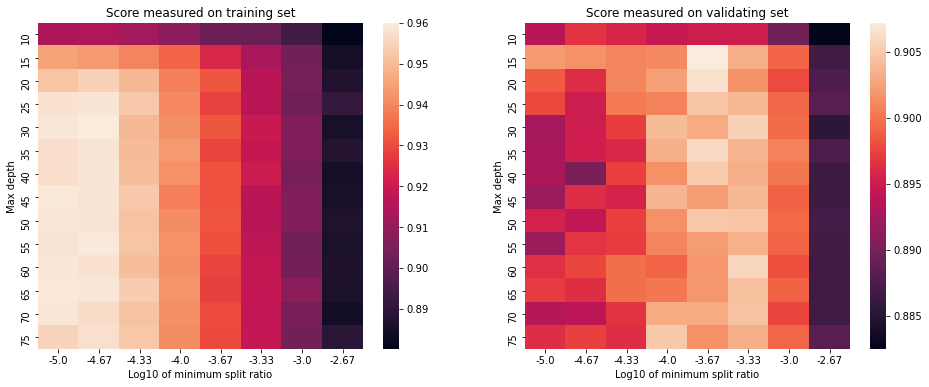

In [444]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("Score measured on training set")
axes[1].title.set_text("Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = scores_train[1:,:8], xticklabels=np.log10(min_splits[:8]).round(2), yticklabels=max_depths[1:])
sns.heatmap(ax = axes[1], data = scores_val[1:,:8], xticklabels=np.log10(min_splits[:8]).round(2), yticklabels=max_depths[1:])
axes[0].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
axes[1].set(xlabel="Log10 of minimum split ratio", ylabel="Max depth")
plt.show()


Widzimy tutaj wyraźne przeuczenie modelu, gdy pozwolimy mu dzielić bardzo małe grupki danych. Patrząc na wynik na zbiorze walidacyjnym widzimy, że optymalny minimalny podział próbek to około 0.0002 (0.02%) liczby wszystkich danych

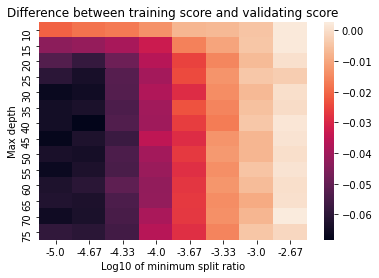

In [448]:
sns.heatmap(data = scores_val[1:,:8] - scores_train[1:,:8], xticklabels=np.log10(min_splits[:8]).round(2), yticklabels=max_depths[1:])
plt.xlabel("Log10 of minimum split ratio")
plt.ylabel("Max depth")
plt.title("Difference between training score and validating score")
plt.show()

In [479]:
np.unravel_index(scores_val[1:,:8].argmax(), (14, 8))

(1, 4)

Najlepszymi parametrami wydają się być ```MathDepth``` = 15 i ```MinSplit``` = 10e-3.67

Sprawdźmy te parametry na zbiorze testowym

In [458]:
rfr = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=np.power(10, -3.67))
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_split=0.00021379620895022324)

In [464]:
rfr.score(X_val, y_val)

0.9081640419066123

In [460]:
rfr.score(X_test, y_test)

0.9125580882971802

Uzyskaliśmy nawet lepszy wynik niż na zbiorze walidacyjnym. 

## XGBoost

Zacznę od domyślnego modelu

In [167]:
xgbr = xgb.XGBRegressor(objective="reg:squarederror")
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [168]:
xgbr.score(X_val, y_val)

0.9085882726147934

In [169]:
xgbr.score(X_test, y_test)

0.9081384700251519

Na powitanie otrzymujemy niemal identyczny (ale minimalnie gorszy) wynik do wcześniej otrzymanego wyniku na zbiorze walidacyjnym.

Teraz przejdę do dostrajania hiperparametrów. Będę badał parametr ```max_depth``` oraz ```learning_rate```.

In [130]:
max_depths = np.arange(4, 24, 1)
learning_rates = np.logspace(-0.5, 0.2, 20)

scores_train = np.empty(shape=(len(max_depths), len(learning_rates)))       # bias
scores_val = np.empty(shape=(len(max_depths), len(learning_rates)))         # variance

In [131]:
for i, depth in enumerate(max_depths):
    for j, lr in enumerate(learning_rates):
        clear_output(wait=True)
        print(f"Evaluating model {i * len(learning_rates) + j} of {len(learning_rates) * len(max_depths)}...\n")
        xgbr = xgb.XGBRegressor(max_depth=depth, learning_rate=lr, n_estimators=5)
        xgbr.fit(X_train, y_train)
        scores_train[i, j] = xgbr.score(X_train, y_train)
        scores_val[i, j] = xgbr.score(X_val, y_val)


Evaluating model 399 of 400...



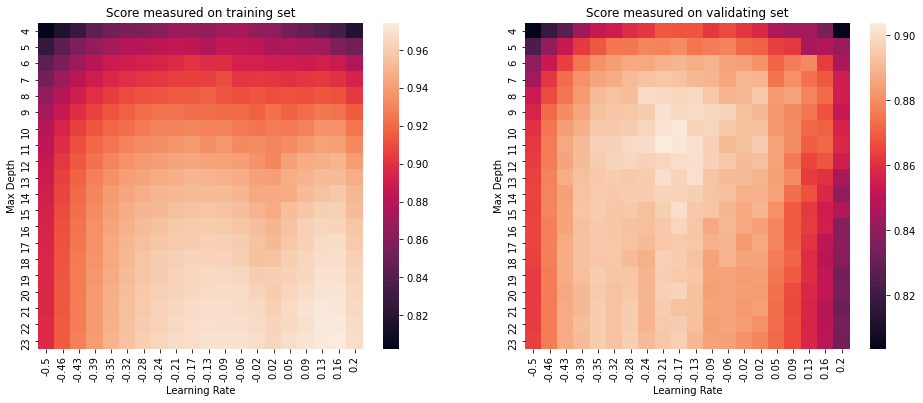

In [132]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].title.set_text("Score measured on training set")
axes[1].title.set_text("Score measured on validating set")

# Ucinam outlierów, aby lepiej było widać skalę problemu
sns.heatmap(ax = axes[0], data = scores_train, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
sns.heatmap(ax = axes[1], data = scores_val, xticklabels=np.log10(learning_rates).round(2), yticklabels=max_depths)
axes[0].set(xlabel="Learning Rate", ylabel="Max Depth")
axes[1].set(xlabel="Learning Rate", ylabel="Max Depth")
plt.show()

Znów widzimy efekty przeuczenia. Najlepsze parametry dla zbioru walidacyjnego to

In [135]:
idxmax = np.unravel_index(scores_val.argmax(), (20, 20))
argmax = max_depths[idxmax[0]], learning_rates[idxmax[1]]
argmax

(11, 0.6233570019315556)

In [161]:
committee_size = np.logspace(0.5, 1.7, 10)
size_score = np.empty(committee_size.shape[0])
for i, cs in enumerate(committee_size):
    xgbr = xgb.XGBRegressor(max_depth=argmax[0], learning_rate=argmax[1], n_estimators=np.int32(cs))
    xgbr.fit(X_train, y_train)
    size_score[i] = xgbr.score(X_val, y_val)

Sprawdzę jeszcze jak liczba estymatorów wpływa na model

<AxesSubplot:>

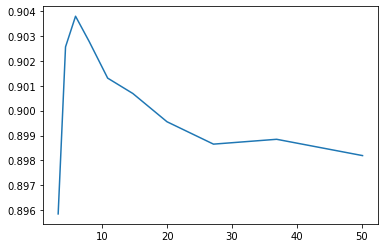

In [162]:
sns.lineplot(x=committee_size, y=size_score)

Widać, że nie koniecznie nim więcej tym lepiej. Najlepszy wynik uzyskaliśmy dla

In [164]:
np.round(committee_size[size_score.argmax()])

6.0

In [165]:
xgbr = xgb.XGBRegressor(max_depth=argmax[0], learning_rate=argmax[1], n_estimators=6)
xgbr.fit(X_train, y_train)
xgbr.score(X_test, y_test)

0.9031500127987185

Niestety wynik jest tylko gorszy. Domyślne wartości XGBoosta dają minimalnie lepsze (ale nadal lepsze) wyniki.